In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [11]:
df = pd.read_excel("/content/sample_data/hotel_reviews.xlsx")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0


In [12]:
# shape of data
df.shape

(20491, 2)

In [13]:
# info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


In [14]:
# Precentage of null values
(df.isna().sum()/len(df))*100

Review    0.0
Rating    0.0
dtype: float64

In [15]:
df.Rating.value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

# EDA

Text(0.5, 1.0, 'Ratings of Hotels')

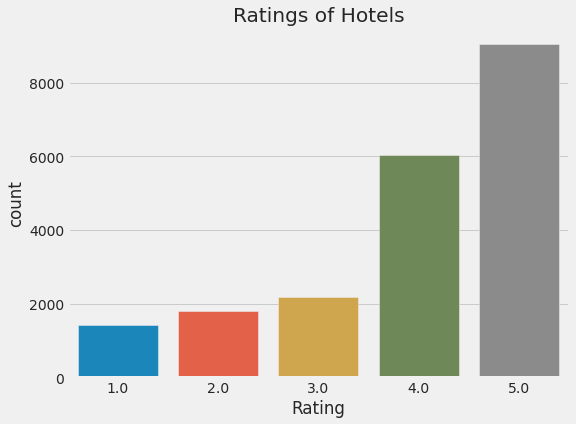

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(df["Rating"])
plt.title("Ratings of Hotels")

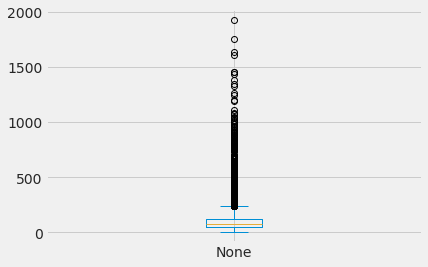

In [17]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in df['Review']])

# The distribution of review text lengths
review_len.plot(kind='box')

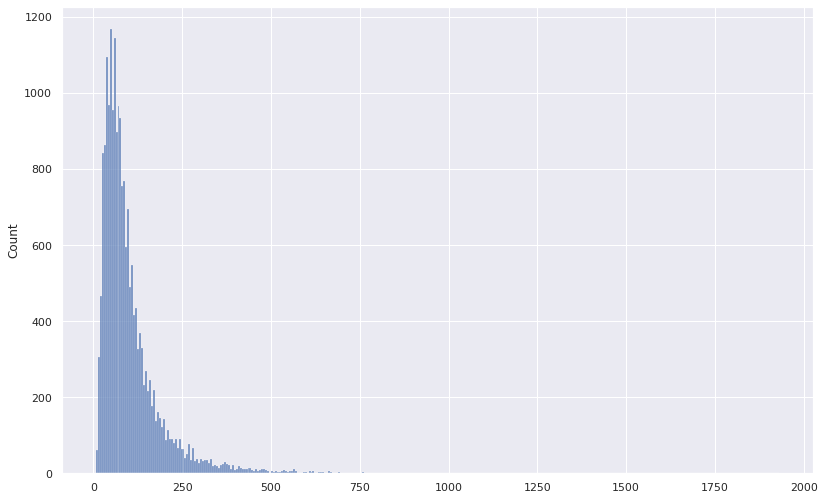

In [18]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)
plt.figure(figsize=(12,8))
sns.histplot(review_len)

count    9054.000000
mean       93.963773
std        90.977999
min         7.000000
25%        44.000000
50%        69.000000
75%       111.000000
max      1755.000000
Name: Length, dtype: float64

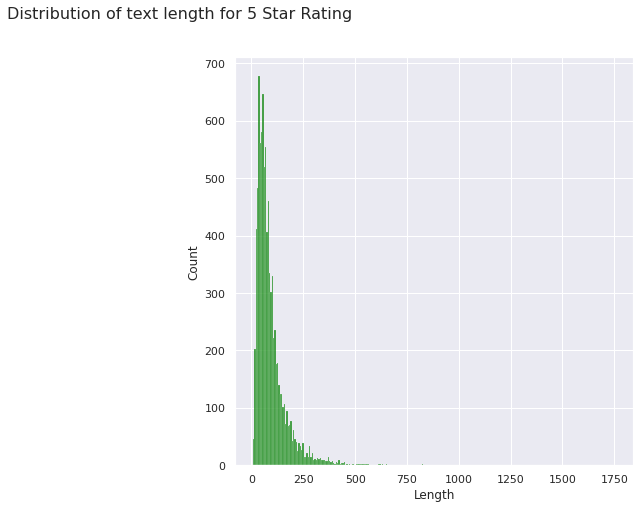

In [19]:
fig = plt.figure(figsize=(14,7))
df["Length"] = df.Review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Rating']==5]['Length'], ax=ax1,color='green')
fig.suptitle('Distribution of text length for 5 Star Rating', fontsize=16)
display(df.Length[df.Rating==5].describe())

count    1421.000000
mean      112.365236
std        99.834855
min        12.000000
25%        51.000000
50%        82.000000
75%       137.000000
max       954.000000
Name: Length, dtype: float64

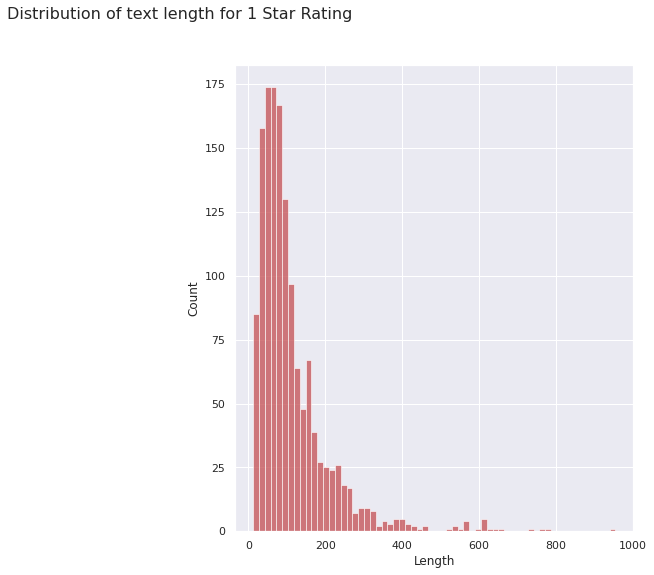

In [20]:
fig2 = plt.figure(figsize=(14,8))
ax2 = fig2.add_subplot(122)
sns.histplot(df[df["Rating"]==1]["Length"],ax=ax2,color='r')
fig2.suptitle("Distribution of text length for 1 Star Rating",fontsize=16)
display(df.Length[df.Rating==1].describe())

## WordCloud

* WordCloud for 1 Star Rating

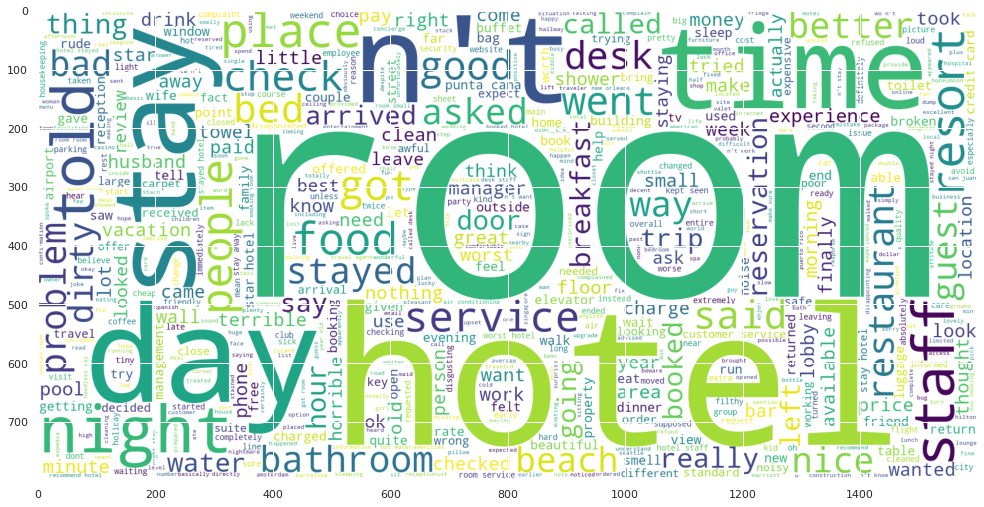

In [21]:
from wordcloud import WordCloud
plt.figure(figsize=(15,15))
wc1 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==1].Review))
plt.imshow(wc1)

* WordCloud for 2 Star Rating

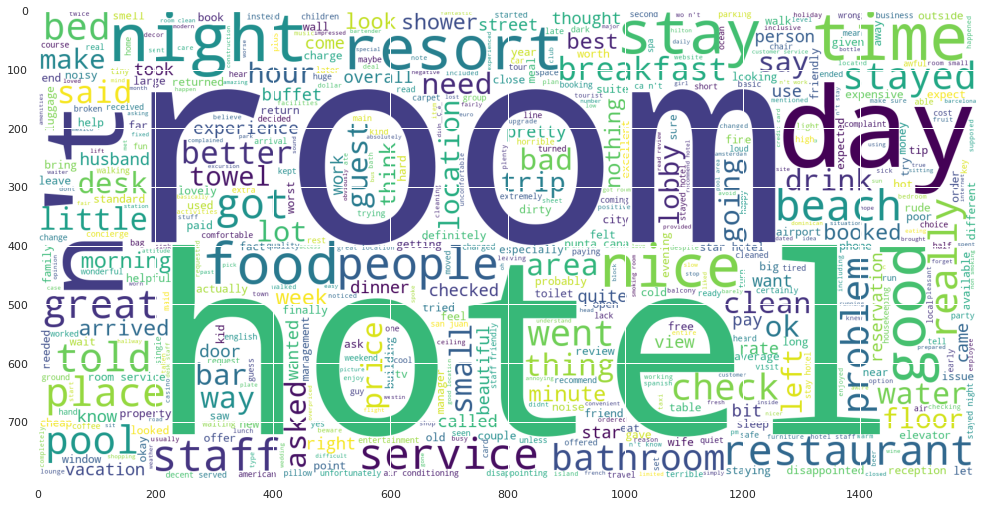

In [22]:
plt.figure(figsize=(15,15))
wc2 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==2].Review))
plt.imshow(wc2)

* WordCloud for 3 Star Rating

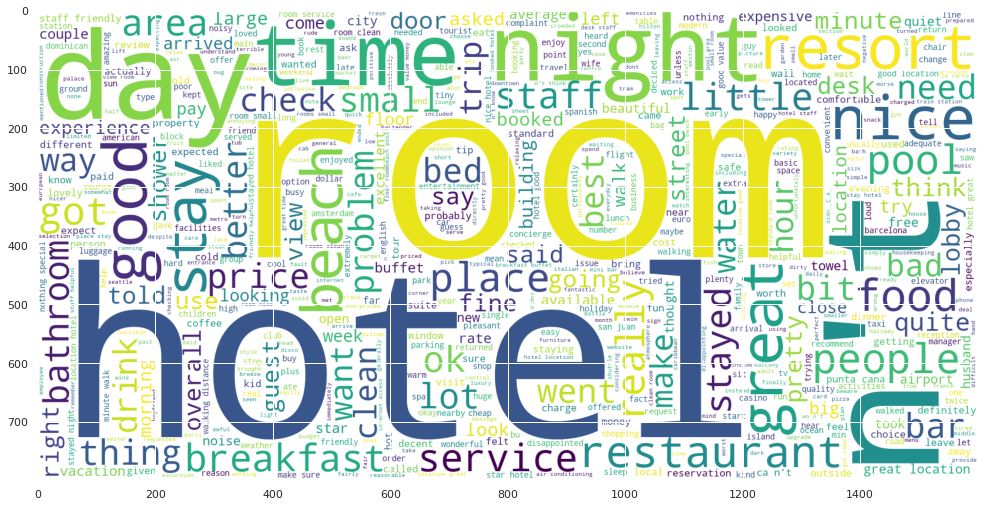

In [23]:
plt.figure(figsize=(15,15))
wc3 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==3].Review))
plt.imshow(wc3)

* WordCloud for 4 Star Rating

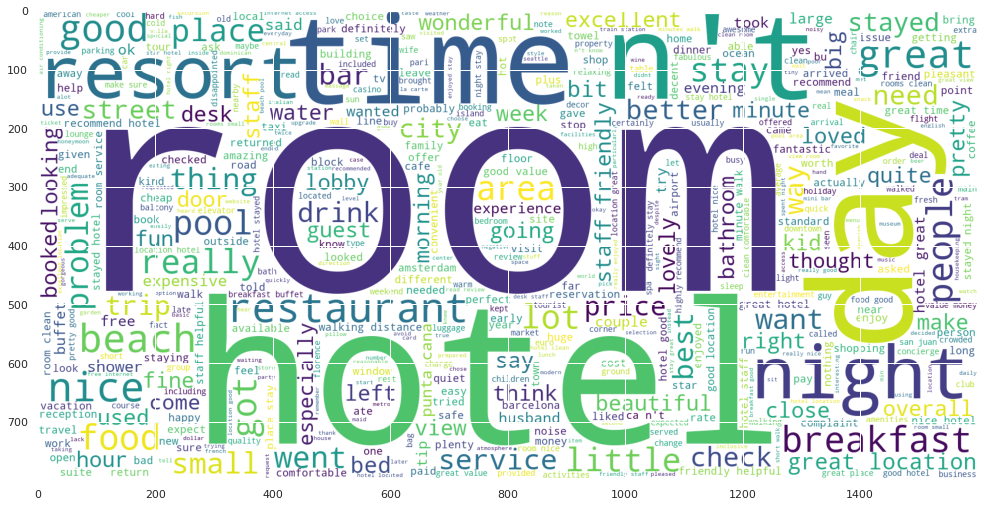

In [24]:
plt.figure(figsize=(15,15))
wc4 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==4].Review))
plt.imshow(wc4)

* WordCloud for 5 Star Rating

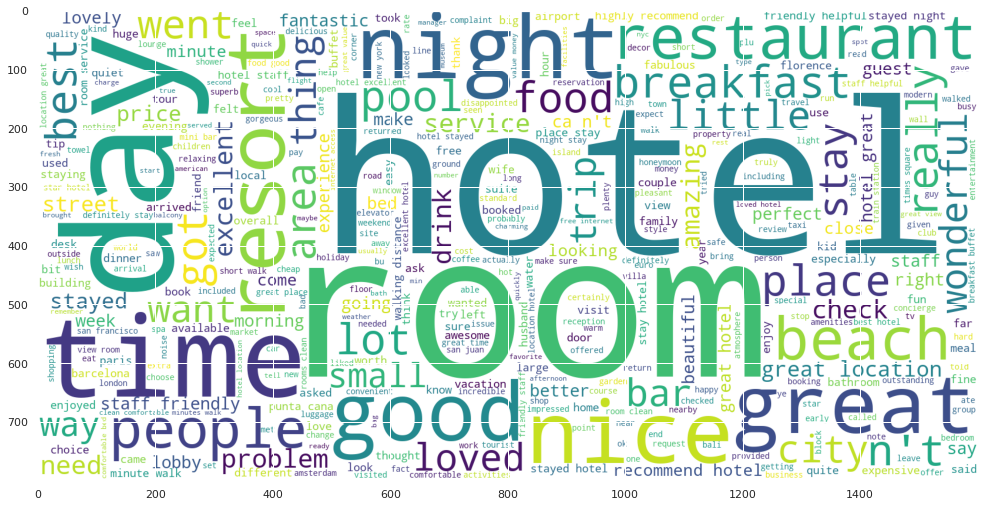

In [25]:
plt.figure(figsize=(15,15))
wc5 = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==5].Review))
plt.imshow(wc5)

# NLP Approach:
1. Cleaning
2. Lemmatization
3. TF-IDF

In [26]:
# function for cleaning Review
def standardize_text(df, field):
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http","")
    df[field] = df[field].str.replace(r"@/S+","")
    df[field] = df[field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.lower()
    return df

In [27]:
standardize_text(df,"Review")

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4.0,87
1,ok nothing special charge diamond member hilto...,2.0,250
2,nice rooms not 4 experience hotel monaco seat...,3.0,217
3,"unique, great stay, wonderful time hotel monac...",5.0,89
4,"great stay great stay, went seahawk game aweso...",5.0,191
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5.0,109
20487,great location price view hotel great quick pl...,4.0,39
20488,"ok just looks nice modern outside, desk staff ...",2.0,63
20489,hotel theft ruined vacation hotel opened sept ...,1.0,781


In [28]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Applying Lemmmatizer to remove tenses from texts.

In [29]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [31]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [32]:
corpus[:1]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night']

In [33]:
def sentiment(review):
    if review>=3:
        return 1
    else:
        return 0
df['Sentiment']= df['Rating'].apply(sentiment)

In [34]:
df.head(10)

,Review,Rating,Length,Sentiment
0,nice hotel expensive parking got good deal sta...,4.0,87,1
1,ok nothing special charge diamond member hilto...,2.0,250,0
2,nice rooms not 4 experience hotel monaco seat...,3.0,217,1
3,"unique, great stay, wonderful time hotel monac...",5.0,89,1
4,"great stay great stay, went seahawk game aweso...",5.0,191,1
5,love monaco staff husband stayed hotel crazy w...,5.0,134,1
6,"cozy stay rainy city, husband spent 7 nights m...",5.0,101,1
7,"excellent staff, housekeeping quality hotel ch...",4.0,85,1
8,"hotel stayed hotel monaco cruise, rooms genero...",5.0,59,1
9,excellent stayed hotel monaco past w e delight...,5.0,35,1


### Applying TF-IDF



In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(corpus)
y = df['Sentiment']

In [37]:
import pickle 

In [38]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

### Splitting data into Training and Testing Set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=24)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15368, 10000)
(15368,)
(5123, 10000)
(5123,)


## Sentiment Analysis

In [40]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [41]:
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Review"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Review"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["Review"]]
print(df.head())

                                              Review  Rating  Length  \
0  nice hotel expensive parking got good deal sta...     4.0      87   
1  ok nothing special charge diamond member hilto...     2.0     250   
2  nice rooms not 4  experience hotel monaco seat...     3.0     217   
3  unique, great stay, wonderful time hotel monac...     5.0      89   
4  great stay great stay, went seahawk game aweso...     5.0     191   

   Sentiment  Positive  Negative  Neutral  
0          1     0.283     0.071    0.646  
1          0     0.196     0.108    0.696  
2          1     0.211     0.107    0.682  
3          1     0.382     0.060    0.558  
4          1     0.221     0.135    0.643  


In [42]:
x = sum(df["Positive"])
y = sum(df["Negative"])
z = sum(df["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive")
    elif (b>a) and (b>c):
        print("Negative")
    else:
        print("Neutral")
sentiment_score(x, y, z)

Neutral


In [43]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  6394.630999999983
Negative:  1478.2819999999986
Neutral:  12618.152999999964


# Model Training...🚴

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9223111458130002

In [45]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

              precision    recall  f1-score   support

           0       0.59      0.88      0.70       538
           1       0.99      0.93      0.96      4585

    accuracy                           0.92      5123
   macro avg       0.79      0.90      0.83      5123
weighted avg       0.94      0.92      0.93      5123

Accuracy of LR Model: 92.23111458130002%


Text(0.5, 1.0, 'Confusion Matrix for LR Model')

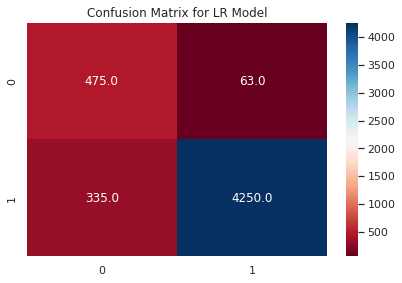

In [46]:
y_pred = lr.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LR Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LR Model")

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

In [48]:
y_pred_proba = lr.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LR Classifier')

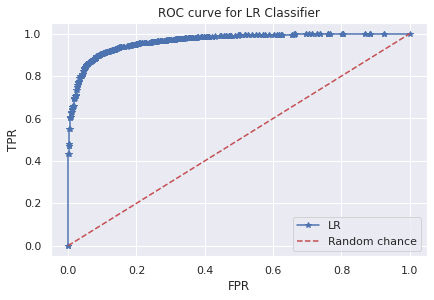

In [49]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LR', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LR Classifier')

### XGBoost

In [50]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier()

In [51]:
xgb.score(X_test, y_test)

0.9002537575639273

              precision    recall  f1-score   support

           0       0.43      0.88      0.57       391
           1       0.99      0.90      0.94      4732

    accuracy                           0.90      5123
   macro avg       0.71      0.89      0.76      5123
weighted avg       0.95      0.90      0.92      5123

Accuracy of XGBOOST Model: 90.02537575639273%


Text(0.5, 1.0, 'Confusion Matrix for XGBOOST Model')

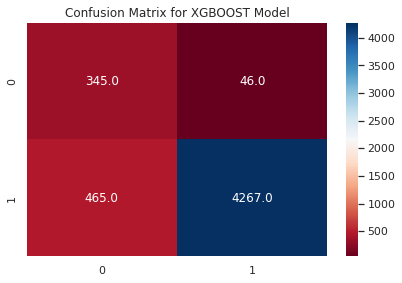

In [52]:
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of XGBOOST Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for XGBOOST Model")

Text(0.5, 1.0, 'ROC curve for XGBOOST Classifier')

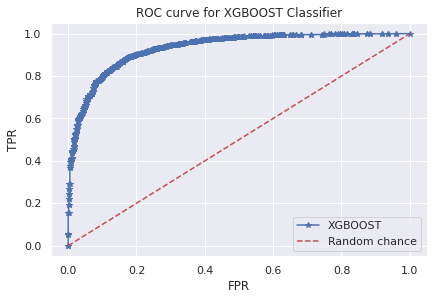

In [53]:
y_pred_proba = xgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['XGBOOST', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for XGBOOST Classifier')

### LightGBM

In [54]:
pip install pickles

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import pickle

In [56]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb.score(X_test, y_test)

0.925434315830568

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       612
           1       0.98      0.94      0.96      4511

    accuracy                           0.93      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.93      0.93      5123

Accuracy of LGBM Model: 92.5434315830568%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

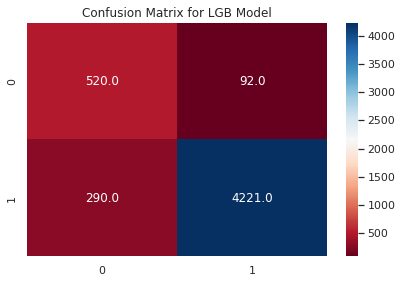

In [57]:
y_pred = lgb.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

In [58]:
pickle.dump(lgb, open('model.pkl', 'wb'))

In [59]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       612
           1       0.98      0.94      0.96      4511

    accuracy                           0.93      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.93      0.93      5123

Accuracy of LGBM Model: 92.5434315830568%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

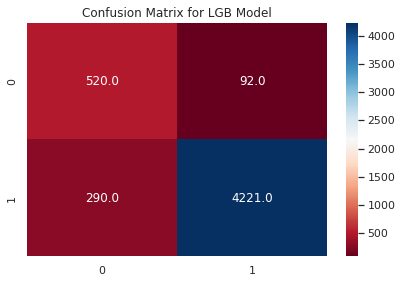

In [60]:
y_pred = pickled_model.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

Text(0.5, 1.0, 'ROC curve for LGB Classifier')

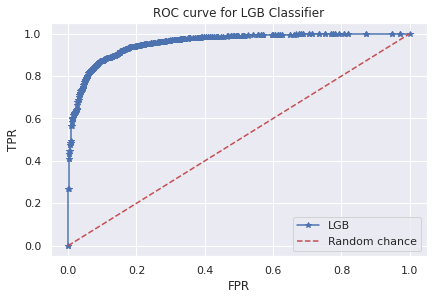

In [61]:
y_pred_proba = lgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGB Classifier')

### Multilayer Perceptron(MLP) Classifier

In [62]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.41066415
Iteration 2, loss = 0.22541545
Iteration 3, loss = 0.14031271
Iteration 4, loss = 0.09690590
Iteration 5, loss = 0.07083846
Iteration 6, loss = 0.05247282
Iteration 7, loss = 0.03842332
Iteration 8, loss = 0.02807516
Iteration 9, loss = 0.02074070
Iteration 10, loss = 0.01560426
Iteration 11, loss = 0.01208678
Iteration 12, loss = 0.00969400
Iteration 13, loss = 0.00798677
Iteration 14, loss = 0.00677670
Iteration 15, loss = 0.00588038
Iteration 16, loss = 0.00520802
Iteration 17, loss = 0.00469016
Iteration 18, loss = 0.00428952
Iteration 19, loss = 0.00395568
Iteration 20, loss = 0.00369847
Iteration 21, loss = 0.00348138
Iteration 22, loss = 0.00329971
Iteration 23, loss = 0.00315190
Iteration 24, loss = 0.00302049
Iteration 25, loss = 0.00290960
Iteration 26, loss = 0.00281260
Iteration 27, loss = 0.00272702
Iteration 28, loss = 0.00265269
Iteration 29, loss = 0.00258431
Iteration 30, loss = 0.00252264
Iteration 31, loss = 0.00246632
Iteration 32, los

MLPClassifier(verbose=True)

In [63]:
mlp.score(X_test, y_test)

0.9238727308217841

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       694
           1       0.97      0.94      0.96      4429

    accuracy                           0.92      5123
   macro avg       0.83      0.87      0.85      5123
weighted avg       0.93      0.92      0.93      5123

Accuracy of MLP Model: 92.38727308217841%


Text(0.5, 1.0, 'Confusion Matrix for MLP Model')

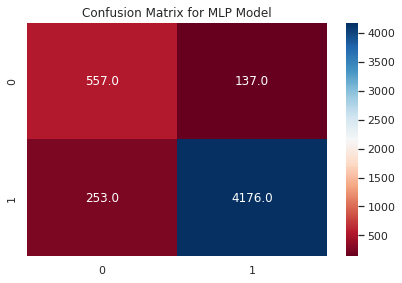

In [64]:
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of MLP Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for MLP Model")

Text(0.5, 1.0, 'ROC curve for MLP Classifier')

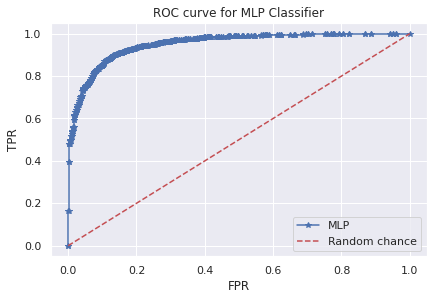

In [65]:
y_pred_proba = mlp.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['MLP', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for MLP Classifier')

### Random Forest 

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 24)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

In [68]:
rf.score(X_test, y_test)

0.8942026156548897

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       694
           1       0.97      0.94      0.96      4429

    accuracy                           0.92      5123
   macro avg       0.83      0.87      0.85      5123
weighted avg       0.93      0.92      0.93      5123

Accuracy of RF Model: 92.38727308217841%


Text(0.5, 1.0, 'Confusion Matrix for RF Model')

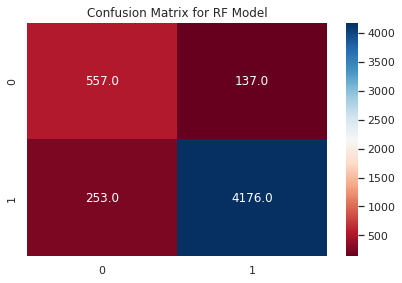

In [69]:
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of RF Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for RF Model")

Text(0.5, 1.0, 'ROC curve for RF Classifier')

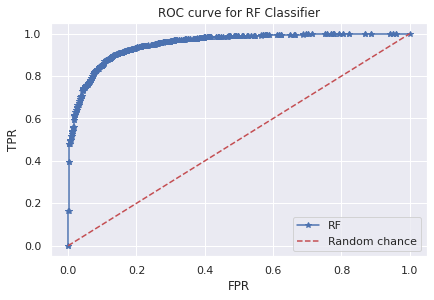

In [70]:
y_pred_proba = mlp.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['RF', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for RF Classifier')

<div class="alert alert-box alert-warning">
Out of all the Models we used, LGBM model performes best with Accuracy of 92.5%.

So, we are considering LGBM Classifier Model.
</div>

# Prediction and Accuracy

In [71]:
y_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       612
           1       0.98      0.94      0.96      4511

    accuracy                           0.93      5123
   macro avg       0.81      0.89      0.84      5123
weighted avg       0.94      0.93      0.93      5123

Accuracy of LGBM Model: 92.5434315830568%


Text(0.5, 1.0, 'Confusion Matrix for LGBM Model')

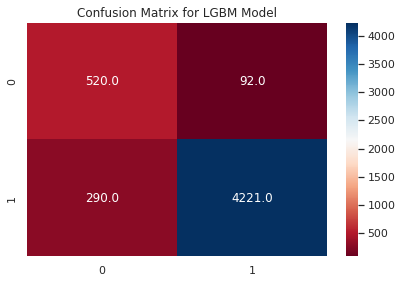

In [72]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGBM Model")

## ROC_AUC Score and Curve
* The receiver operating characteristic (ROC) curve is a plot of the pairs of true positive rates (y-axis) and false positive rates (x-axis) that result from lowering the threshold down from 1, all the way to 0.

In [73]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = lgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LGB Classifier')

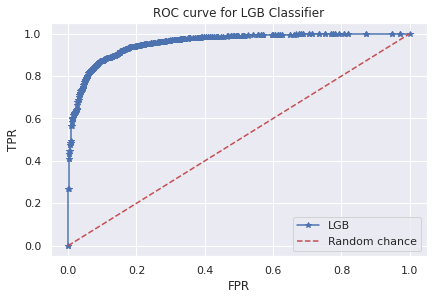

In [74]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGB Classifier')

In [75]:
roc_auc_score(y_test, pos_proba)

0.9547477766041798

* Values closer to 1 in roc_auc_score shows that classifier is efficient and gives better performance.